In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.optimize import fsolve

from sklearn.model_selection import train_test_split
import xgboost as xgb

import matplotlib.pyplot as plt

# from generate_data import generate_feature_vars, generate_example_data, get_feature_keys
from generate_data import DataStatistics, DataGenerator

#!pip install unhcrpyplotstyle

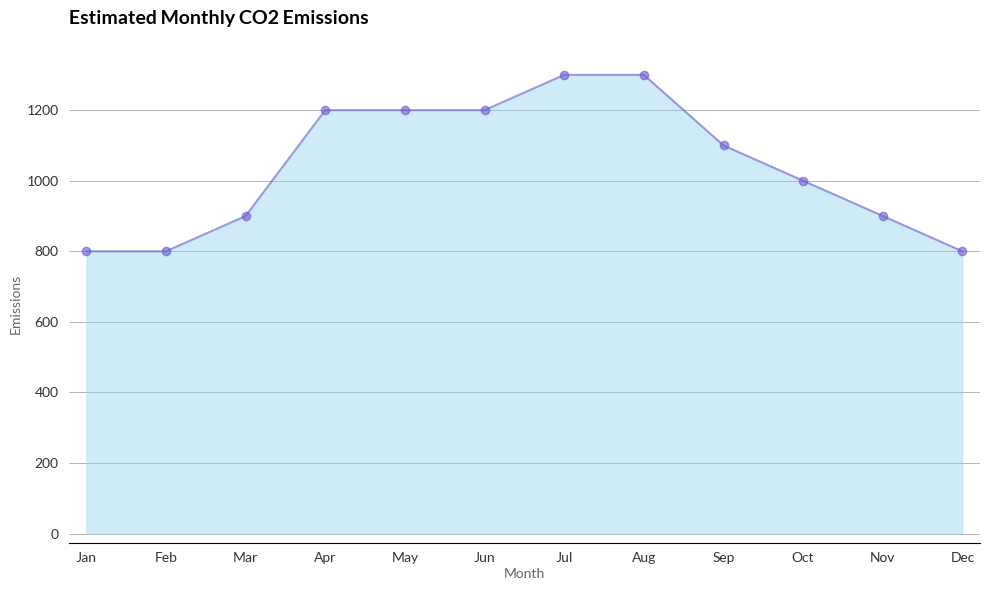

In [59]:
# Example annual data and indices
annual_emissions = 12000  # Total annual emissions
indices = np.array([0.8, 0.8, 0.9, 1.2, 1.2, 1.2, 1.3, 1.3, 1.1, 1.0, 0.9, 0.8])

# Monthly emissions estimation
monthly_emissions = (annual_emissions / 12) * indices

# Plotting
months = range(1, 13)
plt.figure(figsize=(10, 6))
plt.fill_between(months, monthly_emissions, color="skyblue", alpha=0.4)
plt.plot(months, monthly_emissions, marker='o', color='Slateblue', alpha=0.6)
plt.title('Estimated Monthly CO2 Emissions')
plt.xlabel('Month')
plt.ylabel('Emissions')
plt.xticks(ticks=months, labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

In [2]:
class ModelManager:
    """Manages training and storage of machine learning models."""
    def __init__(self, base_path='models/'):
        self.base_path = base_path

    def train_models(self, df, feature_col, target_cols, scope, model='XGB'):
        scope_pathname = self._get_scope_pathname(scope)
        path = f"{self.base_path}{model}_{scope_pathname}_model.p"
        fitted_models = {}
        X = df[feature_col].values
        
        for target_col in target_cols:
            y = df[target_col].values
            loaded_model = pickle.load(open(path, "rb"))
            loaded_model.fit(X, y)
            fitted_models[target_col] = loaded_model
        
        return fitted_models

    @staticmethod
    def _get_scope_pathname(scope):
        if scope == 'Scope 1':
            return 'scope1'
        elif scope == 'Scope 2':
            return 'scope2'
        else:
            return 'total_emissions'


class EmissionsForecaster:
    """Forecasts future emissions based on provided models and data."""
    def forecast_emissions(self, models, last_year_data, num_years_forecast=6, growth_mean=0.3, growth_std=0.5):
        future_data = {}
        for data_type, last_year_value in last_year_data.items():
            growth_rates = np.random.normal(loc=growth_mean, scale=growth_std, size=num_years_forecast)
            future_values = [last_year_value]
            for growth_rate in growth_rates:
                future_value = future_values[-1] * (1 + growth_rate)
                future_values.append(future_value)
            future_data[data_type] = future_values[1:]
        
        df_future_data = pd.DataFrame(future_data, index=np.arange(2023, 2023 + num_years_forecast))
        
        emissions_data = {}
        for emission_type, model in models.items():
            predicted_emissions = []
            for year_index, row in df_future_data.iterrows():
                inputs = row.values.reshape(1, -1)
                emissions = model.predict(inputs)
                if emission_type == 'electricity':
                    emissions *= 0.93 ** (year_index - 2023)  # Apply the decay rate for emissions
                predicted_emissions.append(emissions[0])
            emissions_data[emission_type] = predicted_emissions
        
        return pd.DataFrame(emissions_data, index=np.arange(2023, 2023 + num_years_forecast))

class PlotManager:
    """Plots the data."""
    def plot_scope_forecast(self, df, scope, model_name='Gradient Boosting'):
        plt.style.use(['unhcrpyplotstyle', 'area'])
        x = df.index
        fig, ax = plt.subplots()

        if len(df.columns) <= 4:
            num_cols = len(df.columns)
        else:
            num_cols = np.ceil(len(df.columns)/2).astype(int)
        
        ax.stackplot(x, *[df[col] for col in df.columns], labels=df.columns.tolist(), alpha=0.8)
        ax.axvline(x=2024, color='#666666', linestyle='--', label='Start of Predictions')
        ax.legend(loc=(0,1.05), ncol=num_cols)
        ax.set_title(f'Forecast of {scope} Emissions for the Next 5 Years', pad=50)
        ax.set_ylabel('Emissions (MT CO2e)')
        
        plt.ylim(0, 900)
        plt.xticks(x, x)
        plt.annotate(f"Forecast based on {model_name} Model", (0,0), (0, -40),
                     xycoords='axes fraction', textcoords='offset points',
                     va='top', fontsize=9, color='#666666')
        fig.tight_layout()
        plt.show()


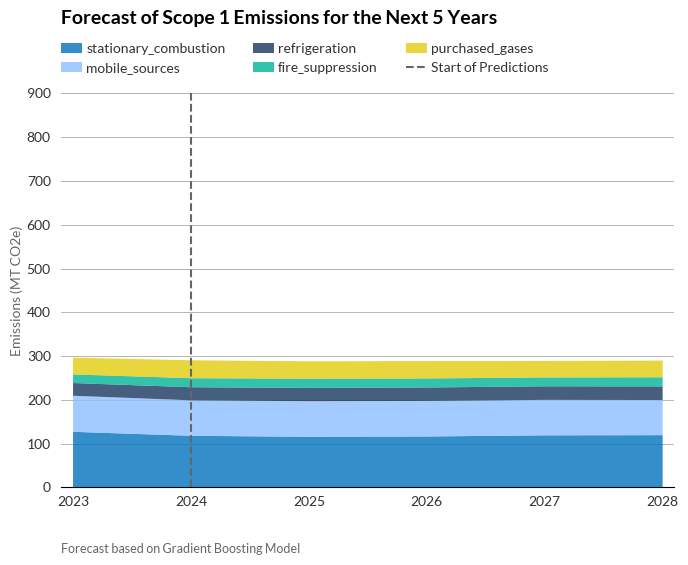

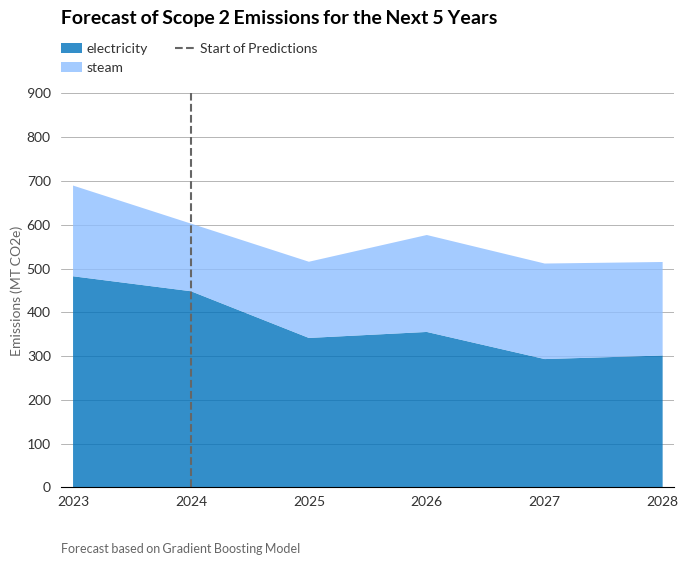

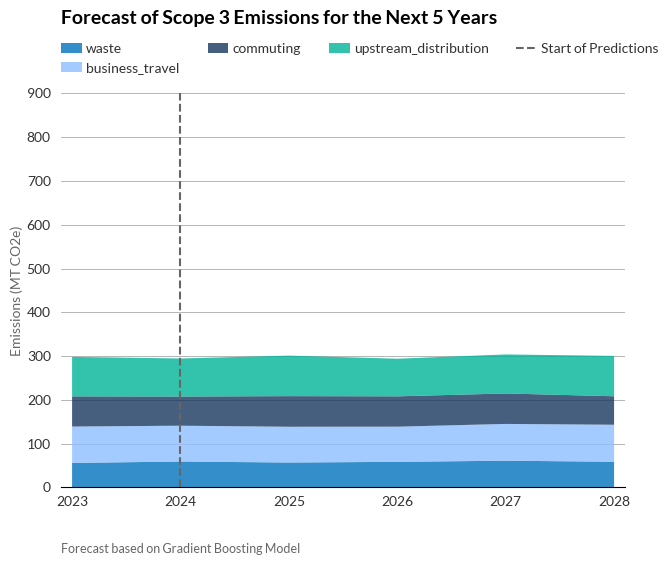

In [4]:
stats = DataStatistics()
data_generator = DataGenerator(stats)
model_manager = ModelManager()
forecast_manager = EmissionsForecaster()
plot_manager = PlotManager()

sample_data = data_generator.generate_example_data()
validation_features_dict = data_generator.generate_feature_vars().loc[0,:].to_dict()

variables_dict = {
    'Scope 1': ['stationary_combustion', 'mobile_sources', 'refrigeration', 'fire_suppression', 'purchased_gases'],
    'Scope 2': ['electricity', 'steam'], 
    'Scope 3': ['waste', 'business_travel', 'commuting', 'upstream_distribution']
}

for scope, emissions in variables_dict.items():
    new_features = stats.get_feature_keys()
    models = model_manager.train_models(df=sample_data, feature_col=new_features, target_cols=emissions, scope=scope)
    emissions_forecast = forecast_manager.forecast_emissions(models, validation_features_dict)
    plot_manager.plot_scope_forecast(emissions_forecast, scope)